In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


In [2]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp

from jax import random

from jax import jit as jjit
from jax import vmap

import matplotlib.pyplot as plt

from functools import partial

jax.__version__

'0.4.31'

In [3]:
import blackjax

In [4]:
jax.devices()

[CudaDevice(id=0)]

In [5]:
jax.config.update('jax_enable_x64', True)

# Priors

In [6]:
def ellip_mag_prior(e, sigma:float=0.3):
    """Unnormalized Prior for the magnitude of the ellipticity, domain is (0, 1)

    This distribution is taken from Gary's 2013 paper on Bayesian shear inference.
    The additional factor on the truncated Gaussian guarantees differentiability
    at e = 0 and e = 1.

    Gary uses 0.3 as a default level of shape noise.
    """
    return (1-e**2)**2 * jnp.exp(-e**2/(2*sigma**2))

def sample_mag_ellip_prior(rng_key, n=1, n_bins=10000, sigma=0.3 ):
    """Sample n points from Gary's ellipticity magnitude prior."""
    # this part could be cached
    e_array = jnp.linspace(0, 1, n_bins)
    p_array = ellip_mag_prior(e_array, sigma=sigma)
    p_array /= jnp.sum(p_array)

    return random.choice(rng_key, e_array, shape=(n,), p=p_array)


2024-09-17 16:21:36.243813: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


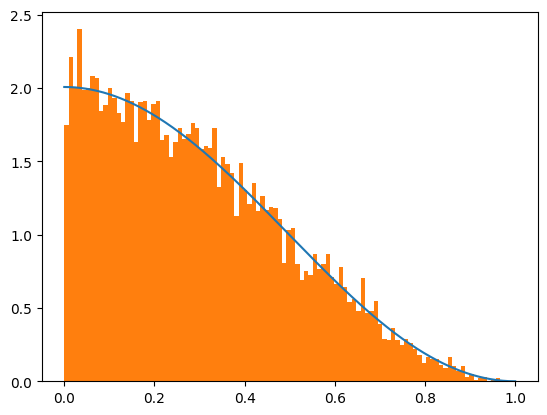

In [7]:
e_array = jnp.linspace(0, 1, 1000)
samples_e = sample_mag_ellip_prior(random.key(42), n=10000, sigma=1.0)

plt.plot(e_array, ellip_mag_prior(e_array, sigma=1.) / 0.498187) # integral 0 to 1 from mathematica for case sigma=1
plt.hist(samples_e, bins=100, density=True)
plt.show()

# see mathematica query: https://www.wolframalpha.com/input?i=%281-x%5E2%29%5E2+*+exp%28-x%5E2+%2F+2%29+integrate+from+0+to+1

In [8]:
def sample_ellip_prior(rng_key, n=1, sigma=0.3):
    """Sample n ellipticities with both components isotropically using Gary's prior for the magnitude."""
    key1, key2 = random.split(rng_key, 2)
    e_mag = sample_mag_ellip_prior(key1, n, sigma=sigma)
    e_phi = random.uniform(key2, shape=(n,), minval=0, maxval=2*jnp.pi)
    e1 = e_mag * jnp.cos(2*e_phi)
    e2 = e_mag * jnp.sin(2*e_phi)
    return jnp.stack((e1, e2), axis=1)

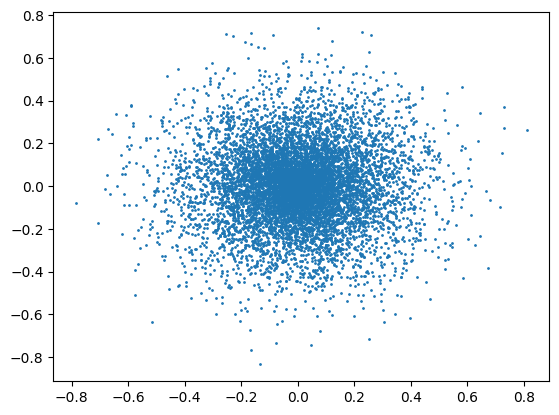

In [9]:
# scatter of ellipticity components
e_sample = sample_ellip_prior(random.key(41), n=10000)
plt.scatter(e_sample[:,0], e_sample[:,1], s=1)
plt.show()

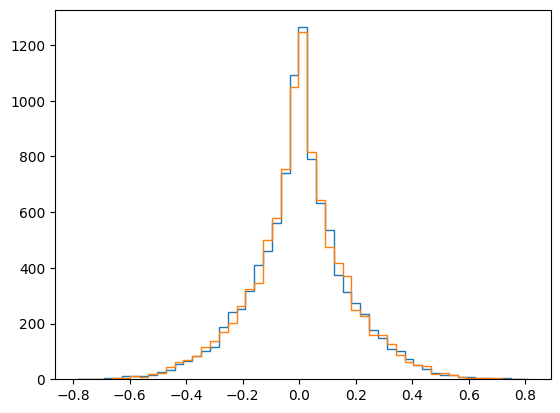

In [10]:
# symmetric
_, bins, _ = plt.hist(e_sample[:, 0], bins=51, histtype='step')
_ = plt.hist(e_sample[:, 1], bins=bins, histtype='step')

In [11]:
def scalar_shear_transformation(e:tuple[float, float], g:tuple[float, float]):
    """Transform elliptiticies by a fixed shear (scalar version).

    The transformation we used is equation 3.4b in Seitz & Schneider (1997).

    NOTE: This function is meant to be vmapped later.
    """
    e1, e2 = e
    g1, g2 = g

    e_comp = e1 + e2 * 1j
    g_comp = g1 + g2 * 1j

    e_prime = (e_comp + g_comp) / (1 + g_comp.conjugate()  * e_comp)
    return e_prime.real, e_prime.imag

def scalar_inv_shear_transformation(e:tuple[float,float], g:tuple[float, float]):
    """Same as above but the inverse."""
    e1, e2 = e
    g1, g2 = g

    e_comp = e1 + e2 * 1j
    g_comp = g1 + g2 * 1j

    e_prime = (e_comp - g_comp) / (1 - g_comp.conjugate()  * e_comp)
    return e_prime.real, e_prime.imag

# useful for jacobian later, only need 2 grads really
inv_shear_func1 = lambda e, g: scalar_inv_shear_transformation(e, g)[0]
inv_shear_func2 = lambda e, g: scalar_inv_shear_transformation(e, g)[1]


def shear_transformation(e, g:tuple[float, float]):
    """Transform elliptiticies by a fixed shear.

    The transformation we used is equation 3.4b in Seitz & Schneider (1997).
    """
    e1, e2 = e[...,0], e[...,1]
    g1, g2 = g

    e_comp = e1 + e2 * 1j
    g_comp = g1 + g2 * 1j

    e_prime = (e_comp + g_comp) / (1 + g_comp.conjugate()  * e_comp)
    return jnp.stack([e_prime.real, e_prime.imag], axis=-1)

def inv_shear_transformation(e, g:tuple[float, float]):
    """Same as above but the inverse."""
    e1, e2 = e[...,0], e[...,1]
    g1, g2 = g

    e_comp = e1 + e2 * 1j
    g_comp = g1 + g2 * 1j

    e_prime = (e_comp - g_comp) / (1 - g_comp.conjugate()  * e_comp)
    return jnp.stack([e_prime.real, e_prime.imag], axis=-1)




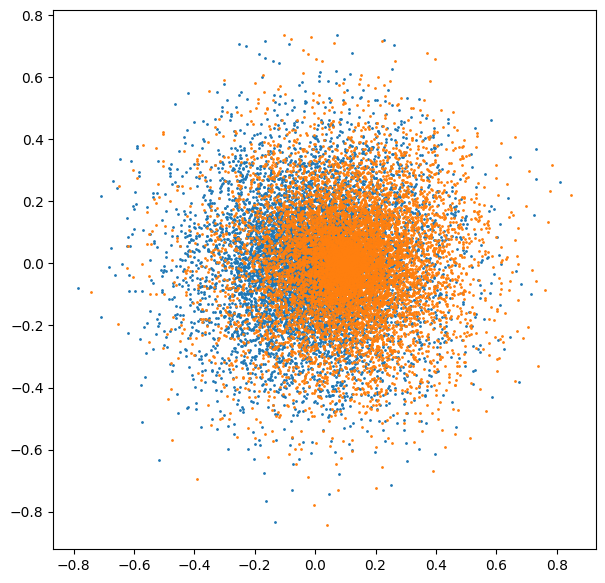

In [12]:
# example of sheared ellipticity shift
plt.figure(figsize=(7,7))
g = 0.1, 0.0
e_sample = sample_ellip_prior(random.key(41), n=10000)
e_sample_prime = shear_transformation(e_sample, g)
plt.scatter(e_sample[:, 0], e_sample[:,1], s=1)
plt.scatter(e_sample_prime[:, 0], e_sample_prime[:, 1], s=1)
plt.show()

In [13]:
# check inverse is correct
e_sample_prime_prime = inv_shear_transformation(e_sample_prime, g)
assert jnp.allclose(e_sample, e_sample_prime_prime).item() # need double precision for this to work, good reminder...

In [14]:
# get synthetic measured sheared ellipticities
def sample_synthetic_sheared_ellips_unclipped(rng_key, g:tuple[float, float], n:int=1, sigma_m:float=0.1, sigma_e:float=0.3):
    """We sample sheared ellipticities from N(e_int + g, sigma_m^2)

    The prior for galaxies is Gary's model for the ellipticity magnitude.

    We generate `m` samples per intrinsic ellipticity.
    """
    key1, key2 = random.split(rng_key, 2)

    e_int = sample_ellip_prior(key1, n, sigma=sigma_e)
    e_sheared = shear_transformation(e_int, g)
    e_obs = random.normal(key2, shape=(n, 2)) * sigma_m + e_sheared.reshape(n, 2)
    return e_obs, e_sheared, e_int

In [15]:
# get synthetic measured sheared ellipticities
def sample_synthetic_sheared_ellips_clipped(rng_key, g:tuple[float, float], n=1, m=10, sigma_m=0.05, sigma_e=1., e_tol=0.99999):
    """We sample sheared ellipticities from N(e_int + g, sigma_m^2)

    The prior for galaxies is Gary's model for the ellipticity magnitude.

    We generate `m` samples per intrinsic ellipticity.
    """
    key1, key2 = random.split(rng_key, 2)

    e_int = sample_ellip_prior(key1, n, sigma=sigma_e)
    e_sheared = shear_transformation(e_int, g)
    e_obs = random.normal(key2, shape=(n, m, 2)) * sigma_m + e_sheared.reshape(n, 1, 2)

    # clip magnitude to < 1
    # preserve angle after noise added when clipping
    beta = jnp.arctan2(e_obs[:, :, 1], e_obs[:, :, 0]) / 2
    e_obs_mag = jnp.sqrt(e_obs[:, :, 0]**2 + e_obs[:, :, 1]**2)
    e_obs_mag = jnp.clip(e_obs_mag, 0, e_tol) # otherwise likelihood explodes

    final_eobs1 = e_obs_mag * jnp.cos(2*beta)
    final_eobs2 = e_obs_mag * jnp.sin(2*beta)
    final_eobs = jnp.stack([final_eobs1, final_eobs2], axis=2)

    return final_eobs, e_int, e_sheared

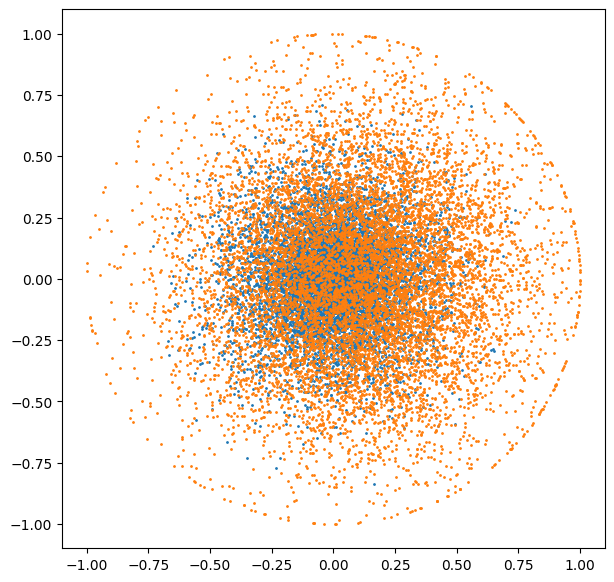

In [16]:
# example with dramatic level of artificial measurement noise
plt.figure(figsize=(7,7))
g = 0.1, 0.0
e_obs, e_int, _ = sample_synthetic_sheared_ellips_clipped(random.key(42), g, n=10000, m=1,
                                                  sigma_m=0.3,
                                                  sigma_e=0.3)
e_obs = e_obs.reshape(-1, 2)
plt.scatter(e_int[:, 0], e_int[:, 1], s=1)
plt.scatter(e_obs[:, 0], e_obs[:, 1], s=1)
plt.show()

In [17]:
# example, 10k galaxy total, each galaxy with 10 samples
e_obs, _, _ = sample_synthetic_sheared_ellips_clipped(random.PRNGKey(42), g,
                                              n=10000, m=10, sigma_m=0.1,
                                              sigma_e=0.3
                                             )
e_obs.shape

(10000, 10, 2)

In [18]:
jnp.sqrt(e_obs[..., 0]**2 + e_obs[..., 1]**2).max() # otherwise explodes likelihood below, cannot be 1. exactly

Array(0.99999, dtype=float64)

## Sample from interim posterior

In [19]:
# interim posterior is of the form N(e_obs | e_s) * P(e_s | I_0) where I_0 is interim prior
# we pick interim prior to be wider the shape noise prior

# should use `sample_synthetic_sheared_ellips_unclipped` for this case

In [20]:
def log_target(e_sheared, e_obs, sigma_m:float=0.1, sigma_e:float=0.3):
    assert e_sheared.shape == (2,) and e_obs.shape== (2,)
    # compute for a single `e_obs` and single `e_sheared`, later vmap
    interim_prior = partial(ellip_mag_prior, sigma=sigma_e * 2) # ignore angle because flat

    e_sheared_mag = jnp.sqrt(e_sheared[0]**2 + e_sheared[1]**2)
    prior = jnp.log(interim_prior(e_sheared_mag)) # enforces |e_sheared| < 1.0 for samples

    likelihood = jnp.sum(jsp.stats.norm.logpdf(e_obs, loc=e_sheared, scale=sigma_m))
    return prior + likelihood


def inference_loop(rng_key, initial_state, kernel, n_samples: int):
    """Function to run a single chain with a given kernel and obtain `n_samples`."""

    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, n_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return (states, infos)

def do_inference(rng_key, init_positions, e_obs, sigma_m=0.1, sigma_e=0.3, m=10):
    _logtarget = partial(log_target, e_obs=e_obs, sigma_m=sigma_m, sigma_e = sigma_e)
    # _lt1 = partial(jax.vmap(log_target, in_axes=(0, 0, None, None)), e_obs=e_obs)

    key1, key2 = random.split(rng_key)

    warmup = blackjax.window_adaptation(
      blackjax.nuts,
      _logtarget,
      progress_bar=False,
      is_mass_matrix_diagonal=True,
      max_num_doublings=5,
      initial_step_size=0.01,
      target_acceptance_rate=0.80,
    )

    (init_states, tuned_params), _ = warmup.run(key1, init_positions, 500)

    kernel = blackjax.nuts(_logtarget, **tuned_params).step
    return inference_loop(key2, init_states, kernel=kernel, n_samples=m)




## Example

In [90]:
g = 0.05, 0.0

In [111]:
e_obs, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(random.key(42), g, n=10000, sigma_m=0.1, sigma_e=0.3)
log_target(e_sheared[0], e_obs[0]) # example

Array(2.52699353, dtype=float64)

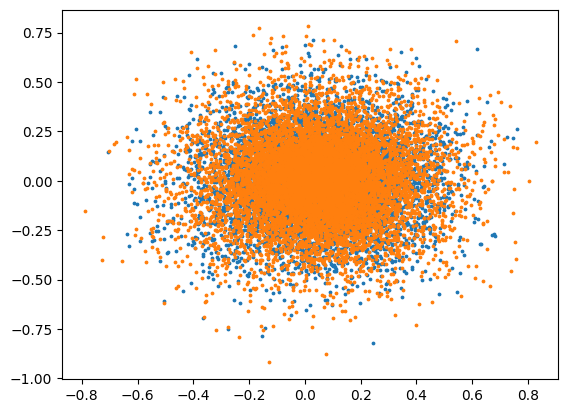

In [112]:
plt.scatter(e_sheared[:, 0], e_sheared[:, 1], s=3)
plt.scatter(e_obs[:, 0], e_obs[:, 1], s=3)

In [113]:
e_obs.shape, e_sheared.shape

((10000, 2), (10000, 2))

In [139]:
e_sheared[0], e_obs[0]

(Array([ 0.08836569, -0.08971897], dtype=float64),
 Array([ 0.07383677, -0.1490064 ], dtype=float64))

In [153]:
# example with 1 chain
# init_positions = {'e_sheared': e_sheared} # truth is initial position
_states, info = do_inference(random.key(41), e_sheared[0], e_obs[0], sigma_m=0.1, m=1000)

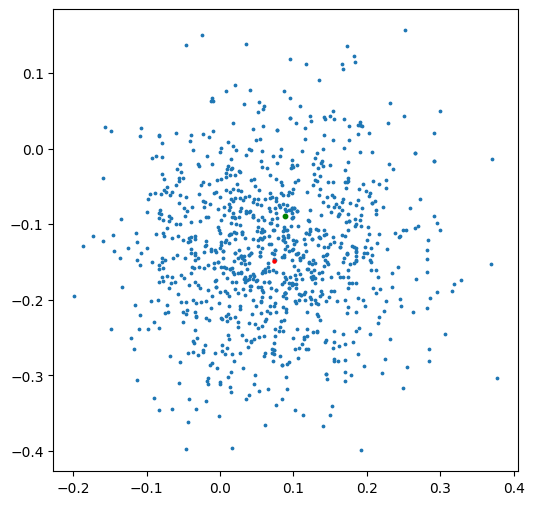

In [154]:
plt.figure(figsize=(6, 6))
e_post = _states.position
plt.scatter(e_post[:, 0], e_post[:, 1], s=3)
plt.scatter(e_obs[0, 0], e_obs[0, 1], color='r', s=5)
plt.scatter(e_sheared[0, 0], e_sheared[0, 1], color='g', s=10)

In [155]:
# multiple chains ~ 1e5
keys = random.split(random.key(42), 10000)
states, info = jax.vmap(do_inference, in_axes=(0, 0, 0))(keys, e_sheared[:10000], e_obs[:10000])

In [156]:
states.position.shape

(10000, 10, 2)

In [159]:
# < 1
e_post = states.position
jnp.sqrt(e_post[..., 0]**2 + e_post[..., 1]**2).max()

Array(0.9422218, dtype=float64)

# Likelihood

In [21]:
from typing import Callable

from jax.scipy.special import logsumexp
# now implement sheared inference procedure assuming K observed samples per galaxy
# ie imagine running mcmc and getting 10 samples per noisy galaxy

# first we need a likelihood which is given by the inference procedure in Schneider et al. 2014

def loglikelihood_fn(g:tuple[float, float], e_obs, prior:Callable, interim_prior:Callable):
    # assume single shear g
    # assume e_obs.shape == (N, K, 2) where N is number of galaxies, K is samples per galaxy
    # the priors are callables for now on only ellipticities
    # the interim_prior should have been used when obtaining e_obs from the chain (i.e. for now same sigma)
    # normalizatoin in priors can be ignored for now as alpha is fixed.
    N,K, _ = e_obs.shape

    e_obs_mag = jnp.sqrt(e_obs[..., 0]**2 + e_obs[..., 1]**2)
    denom = interim_prior(e_obs_mag) # (N, K), can ignore angle in prior as uniform

    # for num we do trick p(w_n' | g, alpha )  = p(w_n' \cross^{-1} g | alpha ) = p(w_n | alpha) * |jac(w_n / w_n')|
    jac1 = jax.vmap(jax.vmap( jax.grad(inv_shear_func1, argnums=0), in_axes=(0, None)), in_axes=(0, None))(e_obs, g) #shape = (N, K, 2)
    jac2 = jax.vmap(jax.vmap( jax.grad(inv_shear_func2, argnums=0), in_axes=(0, None)), in_axes=(0, None))(e_obs, g) #shape = (N, K, 2)
    jac = jnp.stack([jac1, jac2], axis=-1) #shape = (N, K, 2, 2)
    assert jac.shape == (N, K, 2, 2)
    jacdet = jnp.linalg.det(jac) #shape = (N, K)

    e_obs_unsheared = inv_shear_transformation(e_obs, g)
    e_obs_unsheared_mag = jnp.sqrt(e_obs_unsheared[..., 0]**2 + e_obs_unsheared[..., 1]**2)
    num = prior(e_obs_unsheared_mag) * jacdet # (N, K)

    ratio = jnp.log((1/K)) + logsumexp(jnp.log(num) - jnp.log(denom), axis=-1)
    return jnp.sum(ratio)


def _logsumexp(arr):
    max_val = jnp.max(arr)  # Find the maximum value to subtract from the array
    lse = jnp.exp(arr - max_val)
    return lse


## Sanity check likelihood with interim posterior

### Check 1, low noise, normal shape noise

In [228]:
g = 0.05, 0.0
n_gals = 100_000
sigma_m = 0.0001
sigma_e = 0.1 
e_obs, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(random.key(42), g, n=n_gals, sigma_m=sigma_m, sigma_e=sigma_e)
e_obs.shape, e_sheared.shape

((100000, 2), (100000, 2))

In [229]:
keys = random.split(random.key(42), n_gals) 
_do_inference = partial(do_inference, sigma_e=sigma_e, sigma_m=sigma_m, m=10)
states, info = jax.vmap(_do_inference, in_axes=(0, 0, 0))(keys, e_sheared, e_obs) # init position = truth

2024-09-17 15:52:23.957748: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 14.15GiB (15193090452 bytes) by rematerialization; only reduced to 14.36GiB (15424109168 bytes), down from 14.37GiB (15429009368 bytes) originally


In [230]:
e_post = states.position
e_post.shape

(100000, 10, 2)

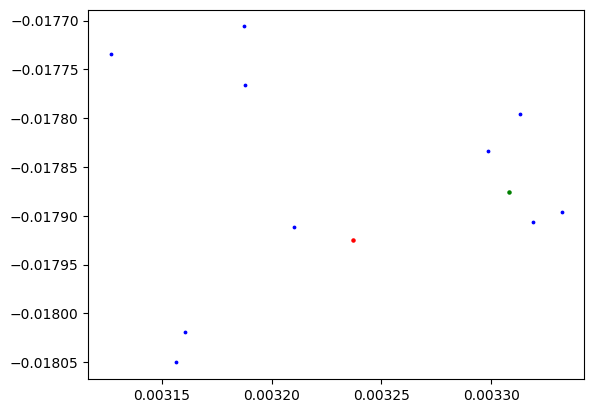

In [231]:
# sanity
plt.scatter(e_post[0, :, 0], e_post[0, :, 1], color='b', s=3)
plt.scatter(e_obs[0, 0], e_obs[0, 1], color='r', s=5)
plt.scatter(e_sheared[0, 0], e_sheared[0, 1], color='g', s=5)

In [232]:
prior = partial(ellip_mag_prior, sigma=sigma_e)
interim_prior = partial(ellip_mag_prior, sigma=sigma_e * 2)
_loglikelihood = jax.jit(partial(loglikelihood_fn, prior=prior, interim_prior=prior))

In [233]:
e_post.shape

(100000, 10, 2)

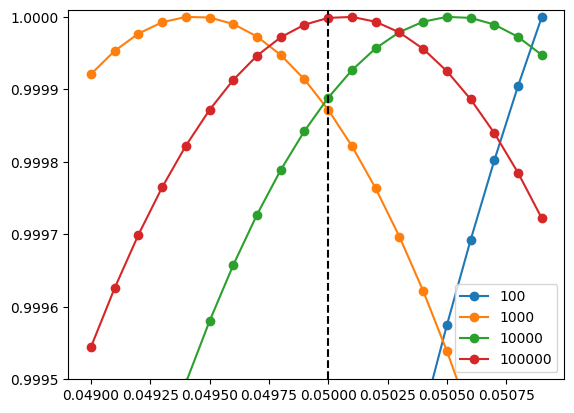

In [234]:
# maximum should (close) to true g
gs = jnp.arange(0.049, 0.051, 0.0001)
for n in (100, 1000, 10_000, 100_000):
    ls = jnp.array([_loglikelihood((_g, 0.), e_post[:n]) for _g in gs])
    assert jnp.all(ls > 0)
    ls = ls / ls.max()
# _ls = _logsumexp(ls) # likelihood not log likeklihood
    plt.plot(gs, ls, '-o', label=f'{n}')
plt.ylim(0.9995, 1.00001)
plt.axvline(0.05, color='k', linestyle='--')
plt.legend()
plt.show()

In [ ]:
# no effect, m=10 -> m=100

## Check 2, low shape noise

In [265]:
g = 0.05, 0.0
n_gals = 100_000
sigma_m = 0.1
sigma_e = 0.001 
e_obs, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(random.key(42), g, n=n_gals, sigma_m=sigma_m, sigma_e=sigma_e)
e_obs.shape, e_sheared.shape

((100000, 2), (100000, 2))

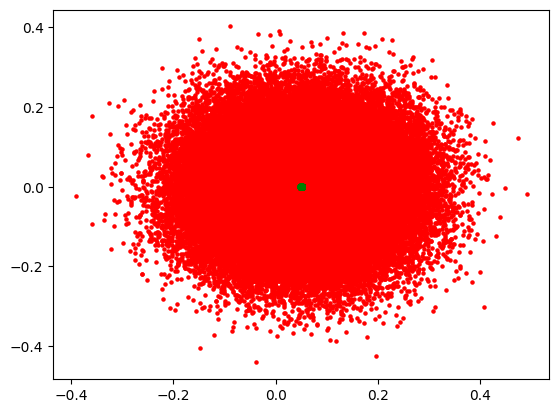

In [266]:
plt.scatter(e_obs[:, 0], e_obs[:, 1], color='r', s=5)
plt.scatter(e_sheared[:, 0], e_sheared[:, 1], color='g', s=5)

In [267]:
keys = random.split(random.key(42), n_gals) 
_do_inference = partial(do_inference, sigma_e=sigma_e, sigma_m=sigma_m, m=10)
states, info = jax.vmap(_do_inference, in_axes=(0, 0, 0))(keys, e_sheared, e_obs) # init position = truth

2024-09-17 15:59:43.023104: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 14.15GiB (15193090452 bytes) by rematerialization; only reduced to 14.36GiB (15424109168 bytes), down from 14.37GiB (15429009368 bytes) originally


In [268]:
e_post = states.position
e_post.shape

(100000, 10, 2)

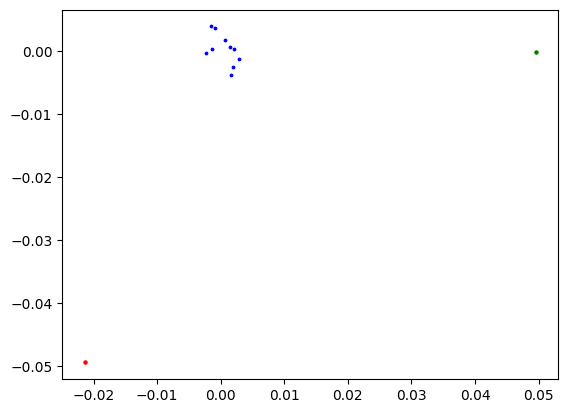

In [269]:
# sanity
plt.scatter(e_post[0, :, 0], e_post[0, :, 1], color='b', s=3)
plt.scatter(e_obs[0, 0], e_obs[0, 1], color='r', s=5)
plt.scatter(e_sheared[0, 0], e_sheared[0, 1], color='g', s=5)

In [270]:
prior = partial(ellip_mag_prior, sigma=sigma_e)
interim_prior = partial(ellip_mag_prior, sigma=sigma_e * 2)
_loglikelihood = jax.jit(partial(loglikelihood_fn, prior=prior, interim_prior=prior))

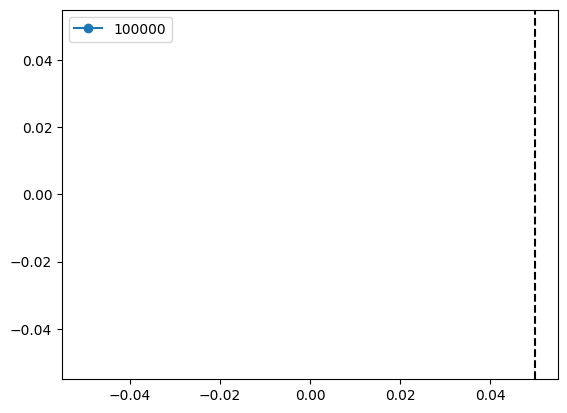

In [271]:
# maximum should (close) to true g
gs = jnp.arange(0.048, 0.053, 0.0001)
for n in (100_000,):
    ls = jnp.array([_loglikelihood((_g, 0.), e_post[:n]) for _g in gs])
    # assert jnp.all(ls > 0)
    # ls = ls / ls.max()
# _ls = _logsumexp(ls) # likelihood not log likeklihood
    plt.plot(gs, ls, '-o', label=f'{n}')
# plt.ylim(0.9995, 1.00001)
plt.axvline(0.05, color='k', linestyle='--')
plt.legend()
plt.show()

## Check 3, both small

In [307]:
g = 0.05, 0.0
n_gals = 100_000
sigma_m = 0.0001
sigma_e = 0.01  # much smaller becomes discrete and weird
e_obs, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(random.key(42), g, n=n_gals, sigma_m=sigma_m, sigma_e=sigma_e)
e_obs.shape, e_sheared.shape

((100000, 2), (100000, 2))

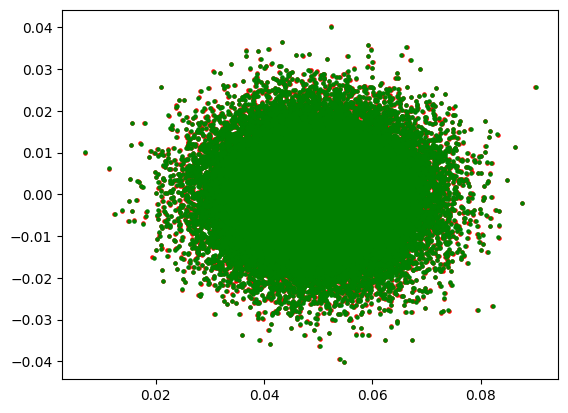

In [308]:
plt.scatter(e_obs[:, 0], e_obs[:, 1], color='r', s=5)
plt.scatter(e_sheared[:, 0], e_sheared[:, 1], color='g', s=5)

In [309]:
keys = random.split(random.key(42), n_gals) 
_do_inference = partial(do_inference, sigma_e=sigma_e, sigma_m=sigma_m, m=10)
states, info = jax.vmap(_do_inference, in_axes=(0, 0, 0))(keys, e_sheared, e_obs) # init position = truth

2024-09-17 16:04:49.643483: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 14.15GiB (15193090452 bytes) by rematerialization; only reduced to 14.36GiB (15424109168 bytes), down from 14.37GiB (15429009368 bytes) originally


In [310]:
e_post = states.position
e_post.shape

(100000, 10, 2)

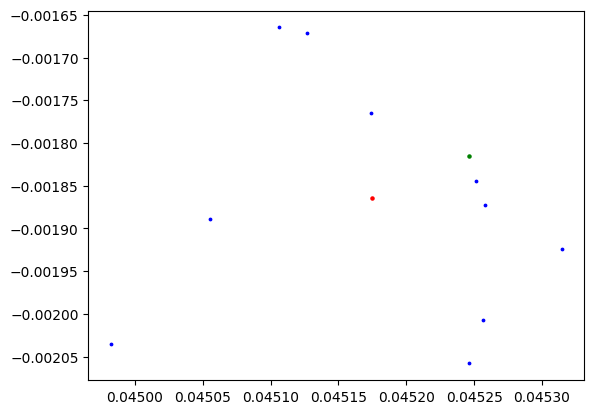

In [311]:
# sanity
plt.scatter(e_post[0, :, 0], e_post[0, :, 1], color='b', s=3)
plt.scatter(e_obs[0, 0], e_obs[0, 1], color='r', s=5)
plt.scatter(e_sheared[0, 0], e_sheared[0, 1], color='g', s=5)

In [312]:
prior = partial(ellip_mag_prior, sigma=sigma_e)
interim_prior = partial(ellip_mag_prior, sigma=sigma_e * 2)
_loglikelihood = jax.jit(partial(loglikelihood_fn, prior=prior, interim_prior=prior))

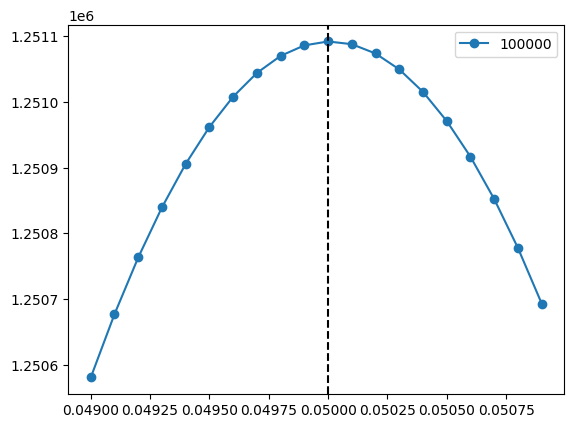

In [314]:
# maximum should (close) to true g
gs = jnp.arange(0.049, 0.051, 0.0001)
for n in (100_000,):
    ls = jnp.array([_loglikelihood((_g, 0.), e_post[:n]) for _g in gs])
    # assert jnp.all(ls > 0)
    # ls = ls / ls.max()
# _ls = _logsumexp(ls) # likelihood not log likeklihood
    plt.plot(gs, ls, '-o', label=f'{n}')
# plt.ylim(0.9995, 1.00001)
plt.axvline(0.05, color='k', linestyle='--')
plt.legend()
plt.show()

## Check 4, enough samples but realitisc shape noise and observation noise

In [25]:
g = 0.05, 0.0
n_gals = int(1e5)
sigma_m = 0.05
sigma_e = 0.3  # much smaller becomes discrete and weird

key = jax.random.key(42)
key1, key2 = jax.random.split(key)

e_obs, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(key1, g, n=n_gals, sigma_m=sigma_m, sigma_e=sigma_e)
e_obs.shape, e_sheared.shape

((100000, 2), (100000, 2))

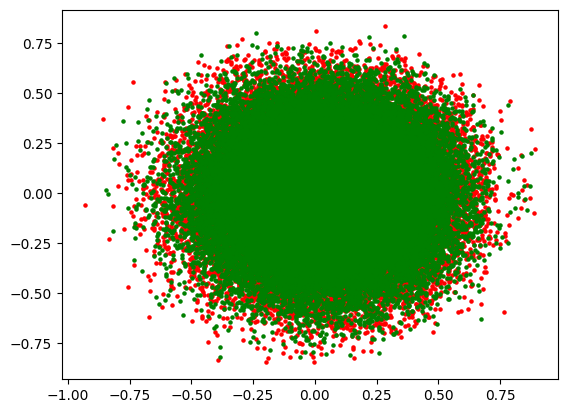

In [26]:
max_n_gal = int(1e5)
plt.scatter(e_obs[:max_n_gal, 0], e_obs[:max_n_gal, 1], color='r', s=5)
plt.scatter(e_sheared[:max_n_gal, 0], e_sheared[:max_n_gal, 1], color='g', s=5)

In [27]:
keys2 = random.split(key2, n_gals) 
_do_inference = partial(do_inference, sigma_e=sigma_e, sigma_m=sigma_m, m=10)
states, info = jax.vmap(_do_inference, in_axes=(0, 0, 0))(keys2, e_sheared, e_obs) # init position = truth

2024-09-17 16:22:28.802307: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 14.15GiB (15193090452 bytes) by rematerialization; only reduced to 14.36GiB (15424109168 bytes), down from 14.37GiB (15429009368 bytes) originally


In [28]:
# keys2 = jax.random.split(key2, 10)
# samples = []
# for ii in range(10):
#     es1 = e_sheared[ii*int(1e5):(ii+1)*int(1e5)]
#     e_obs1 = e_obs[ii*int(1e5): (ii+1)*int(1e5)]
#     k = keys2[ii]
#     ks = jax.random.split(k, int(1e5))
#     _do_inference = partial(do_inference, sigma_e=sigma_e, sigma_m=sigma_m, m=10)
#     states, info = jax.vmap(_do_inference, in_axes=(0, 0, 0))(ks, es1, e_obs1) # init position = truth
#     samples.append(states.position)

In [29]:
e_post = states.position
e_post.shape

(100000, 10, 2)

In [30]:
# e_post = states.position
# e_post.shape

In [31]:
# # sanity
# plt.scatter(e_post[0, :, 0], e_post[0, :, 1], color='b', s=3)
# plt.scatter(e_obs[0, 0], e_obs[0, 1], color='r', s=5)
# plt.scatter(e_sheared[0, 0], e_sheared[0, 1], color='g', s=5)

In [32]:
prior = partial(ellip_mag_prior, sigma=sigma_e)
interim_prior = partial(ellip_mag_prior, sigma=sigma_e * 2)
_loglikelihood = jax.jit(partial(loglikelihood_fn, prior=prior, interim_prior=prior))

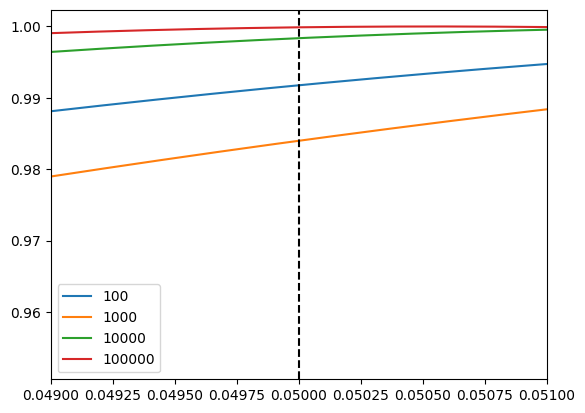

In [43]:
# maximum should (close) to true g
gs = jnp.arange(0.045, 0.055, 0.00001)
for n in (100, 1000, 10_000, 100_000):
    ls = jnp.array([_loglikelihood((_g, 0.), e_post[:n]) for _g in gs])
    assert jnp.all(ls > 0)
    ls = ls / ls.max()
# _ls = _logsumexp(ls) # likelihood not log likeklihood
    plt.plot(gs, ls, '-', label=f'{n}')
# plt.ylim(0.9995, 1.00001)
plt.axvline(0.05, color='k', linestyle='--')
plt.legend()
plt.xlim(0.049, 0.051)

plt.show()
# plt.axhline(1.0)

## Likelihood withh 'obs' samples directly (?)

In [19]:
# setup
sigma_e = 0.3 # Gary's setup
prior = partial(ellip_mag_prior, sigma=sigma_e)
interim_prior = partial(ellip_mag_prior, sigma=sigma_e * 2)

# setup funcs
loglikelihood = jax.jit(partial(loglikelihood_fn, prior=prior, interim_prior=interim_prior))
grad_loglikelihood = jax.jit(jax.grad(loglikelihood, argnums=0))

In [25]:
g = 0.05, 0.
sigma_m = 0.00 # gary uses ~ > 0.1
n_samples_per_galaxy = 10
seed = 41

n_gals = int(1e6)


In [26]:

# compilation
e_obs_comp, _, _ = sample_synthetic_sheared_ellips(random.PRNGKey(seed), g,
                                              n=100,
                                              m=n_samples_per_galaxy,
                                              sigma_m=sigma_m,
                                              sigma_e=sigma_e
                                             )

e_obs, _, _ = sample_synthetic_sheared_ellips(random.PRNGKey(seed), g,
                                              n=n_gals,
                                              m=n_samples_per_galaxy,
                                              sigma_m=sigma_m,
                                              sigma_e=sigma_e
                                             )

e_obs_comp.shape, e_obs.shape


((100, 10, 2), (1000000, 10, 2))

In [27]:
 # compile
loglikelihood(g, e_obs_comp), grad_loglikelihood(g, e_obs_comp)

(Array(-19.75306692, dtype=float64),
 (Array(-31.34833586, dtype=float64, weak_type=True),
  Array(5.07948906, dtype=float64, weak_type=True)))

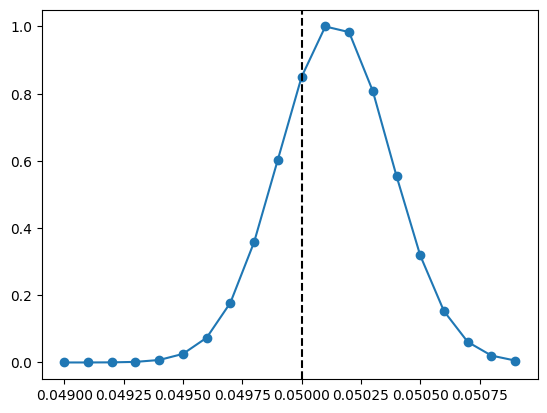

In [29]:
# maximum should (close) to true g
gs = jnp.arange(0.049, 0.051, 0.0001)
ls = jnp.array([loglikelihood((_g, 0.), e_obs) for _g in gs])
_ls = _logsumexp(ls) # likelihood not log likeklihood
plt.plot(gs, _ls, '-o')
plt.axvline(0.05, color='k', linestyle='--')
plt.show()

In [1]:
(0.05 - 0.05025) / 0.05

-0.0050000000000000044

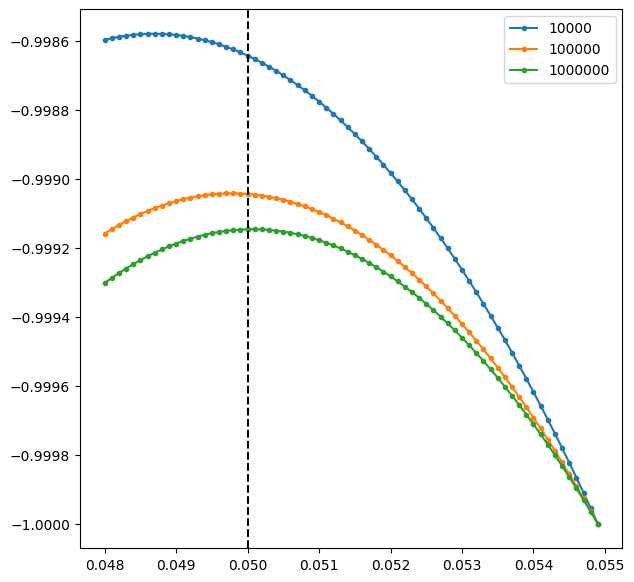

In [ ]:
# maximum should (close) to true g
plt.figure(figsize=(7,7))
gs = jnp.arange(0.048, 0.055, 0.0001)
for ii in (10_000, 100_000, 1_000_000):
  es = e_obs[:ii]
  assert es.shape[0] == ii
  ls = jnp.array([loglikelihood((_g, 0.), es) for _g in gs])
  ls = [l / jnp.max(jnp.abs(ls)) for l in ls]
  plt.plot(gs, ls, '-o', label=f"{ii}", ms=3)
plt.axvline(0.05, color='k', linestyle='--')
plt.legend()
plt.show()

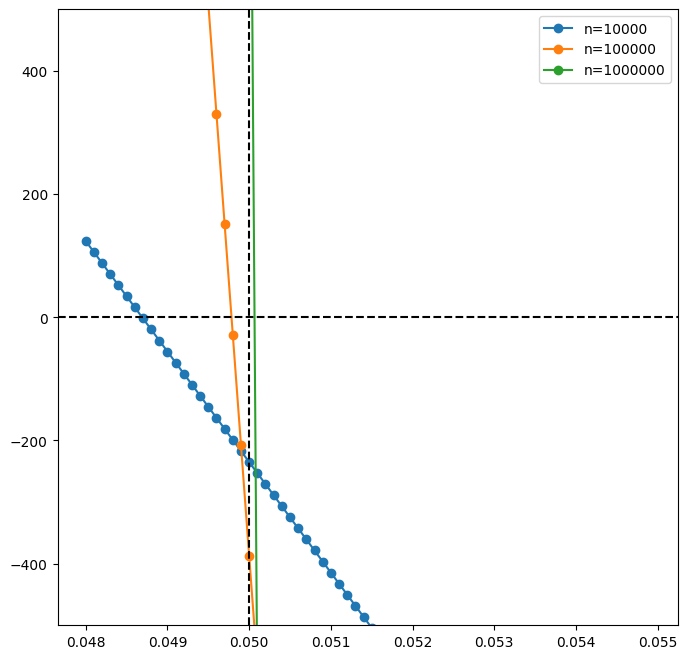

In [ ]:
# gradient is 0 at truth?
gs = jnp.arange(0.048, 0.055, 0.0001)


plt.figure(figsize=(8,8))

for ii in (10_000,100_000, 1_000_000):
  grad_ls = [grad_loglikelihood((_g, 0.), e_obs[:ii])[0] for _g in gs]
  # grad_ls = [g / max(grad_ls) for g in grad_ls]
  plt.plot(gs, grad_ls, '-o', label=f'n={ii}')

plt.axvline(0.05, color='k', linestyle='--')
plt.axhline(0.0, color='k', linestyle='--')

# plt.xlim(0.04, 0.06)
plt.legend()
plt.ylim(-500, 500)

plt.show()
# gets closer to truth as noise -> 0 and shape_noise -> 0
# as n_gals increases (?)b

In [ ]:
# bias example:
(0.0550 - 0.05) / 0.05 #10%, need <= 0.1%

0.09999999999999995

# Figure out Jacobian

In [ ]:
a = jnp.zeros((4, 2)) + 1.
b = jnp.zeros((4, 2)) + 2.
c = jnp.stack([a, b], axis=-1)
c.shape,jnp.linalg.det(c).shape

((4, 2, 2), (4,))

In [ ]:
jax.jacobian?

Object `jax.jacobian` not found.


In [ ]:
# jax.jacobian(inv_shear_transformation, argnums=0)(e_obs, g)

In [ ]:
e_obs.shape, g

((10000, 10, 2), (0.1, 0.0))

In [ ]:
e_obs[0, 0, :].shape

(2,)

In [ ]:
inv_shear_transformation(e_obs[0, 0, :], g)

Array([-0.11331286, -0.16029811], dtype=float64)

In [ ]:
jax.jacobian(inv_shear_transformation, argnums=0)(e_obs[0, 0, :], g)

Array([[ 0.98707967,  0.03201651],
       [-0.03201651,  0.98707967]], dtype=float64)

In [ ]:
scalar_shear_transformation(e_obs[0, 0, :], g)

(Array(0.09187884, dtype=float64), Array(-0.16099409, dtype=float64))

In [ ]:
jax.jacobian(inv_scalar_shear_transformation, argnums=0)(e_obs[0, 0, :], g)

(Array([0.98707967, 0.03201651], dtype=float64),
 Array([-0.03201651,  0.98707967], dtype=float64))

In [ ]:
inv_shear_transformation(e_obs[0, :, :], g)

Array([[-0.11331286, -0.16029811],
       [ 0.09533936,  0.0508395 ],
       [ 0.17543176, -0.08847371],
       [ 0.24269971,  0.01354451],
       [-0.04027512,  0.02180715],
       [-0.00350546, -0.08995532],
       [ 0.08476432,  0.07942145],
       [ 0.15945277, -0.02185013],
       [ 0.09973074,  0.02283901],
       [ 0.04774073, -0.13511583]], dtype=float64)

In [ ]:
jax.vmap(inv_scalar_shear_transformation, in_axes=(0, None))(e_obs[0, :, :], g)

(Array([-0.11331286,  0.09533936,  0.17543176,  0.24269971, -0.04027512,
        -0.00350546,  0.08476432,  0.15945277,  0.09973074,  0.04774073],      dtype=float64),
 Array([-0.16029811,  0.0508395 , -0.08847371,  0.01354451,  0.02180715,
        -0.08995532,  0.07942145, -0.02185013,  0.02283901, -0.13511583],      dtype=float64))

In [ ]:
jax.jacobian(inv_shear_transformation, argnums=0)(e_obs[0, :, :], g).shape

(10, 2, 10, 2)

In [ ]:
a, b = jax.jacobian(jax.vmap(inv_scalar_shear_transformation, in_axes=(0, None)), argnums=0)(e_obs[0, :, :], g)
a.shape

(10, 10, 2)

In [ ]:
for ii in range(10):
  print(a[ii, ii])
print()
for ii in range(10):
  print(b[ii, ii])

[0.98707967 0.03201651]
[ 1.02942719 -0.01036853]
[1.04577357 0.01818703]
[ 1.05972438 -0.00280267]
[ 1.0019762  -0.00438774]
[1.00931122 0.01816642]
[ 1.02723398 -0.01618074]
[1.04256569 0.00448455]
[ 1.03034383 -0.00465996]
[1.01958422 0.02742644]

[-0.03201651  0.98707967]
[0.01036853 1.02942719]
[-0.01818703  1.04577357]
[0.00280267 1.05972438]
[0.00438774 1.0019762 ]
[-0.01816642  1.00931122]
[0.01618074 1.02723398]
[-0.00448455  1.04256569]
[0.00465996 1.03034383]
[-0.02742644  1.01958422]


In [ ]:
inv_shear_func1 = lambda e, g: inv_scalar_shear_transformation(e, g)[0]
inv_shear_func2 = lambda e, g: inv_scalar_shear_transformation(e, g)[1]

jax.vmap(jax.grad(inv_shear_func1), in_axes=(0, None))(e_obs[0, :, :], g), jax.vmap(jax.grad(inv_shear_func2), in_axes=(0, None))(e_obs[0, :, :], g)


(Array([[ 0.98707967,  0.03201651],
        [ 1.02942719, -0.01036853],
        [ 1.04577357,  0.01818703],
        [ 1.05972438, -0.00280267],
        [ 1.0019762 , -0.00438774],
        [ 1.00931122,  0.01816642],
        [ 1.02723398, -0.01618074],
        [ 1.04256569,  0.00448455],
        [ 1.03034383, -0.00465996],
        [ 1.01958422,  0.02742644]], dtype=float64),
 Array([[-0.03201651,  0.98707967],
        [ 0.01036853,  1.02942719],
        [-0.01818703,  1.04577357],
        [ 0.00280267,  1.05972438],
        [ 0.00438774,  1.0019762 ],
        [-0.01816642,  1.00931122],
        [ 0.01618074,  1.02723398],
        [-0.00448455,  1.04256569],
        [ 0.00465996,  1.03034383],
        [-0.02742644,  1.01958422]], dtype=float64))

In [ ]:
jax.vmap(jax.vmap(jax.grad(inv_shear_func1), in_axes=(0, None)), in_axes=(0, None))(e_obs[:, :, :], g).shape

(10000, 10, 2)